# Problem statement

### Equation problem

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_\inf}{T_{b} - T_{\inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_\inf)}$


- $\epsilon_G=\epsilon(T_b-T_\inf)$


- $\epsilon_C=\beta(T_b-T_\inf)$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$

In [1]:
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K

In [2]:
NUM_DATA_TRAINING = 10 

In [3]:
import torch
import imageio
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import SGD, LBFGS, Adam, RMSprop, SparseAdam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Load dataset

In [4]:
relative_csv_path = "./../src/data/raw/Dataset.csv"
split_ratio = 0.2

# Load different temperatures samples 
fields = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
X_train, X_test = train_test_split(df_T, test_size = split_ratio)

# Load different G values 
fields = ['G']
df_G = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
Y_train, Y_test = train_test_split(df_G, test_size = split_ratio)

### Print shape and sizes

In [5]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
Y_train = Y_train.to_numpy()
Y = df_T.to_numpy()

# Compute columns shampes
num_col_X = X_train.shape[1]
num_col_Y = Y_train.shape[1]

# print("X_test information:")
# print("the size of X_test is", X_test.size)
# print("the shape of X_test is", X_test.shape)

# print("X_train information:")
# print("the size of X_train is", X_train.size)
# print("the shape of X_train is", X_train.shape)

# print("Y_train information:")
# print("the size of Y_train is", Y_train.size)
# print("the shape of Y_train is", Y_train.shape)

# print("Y_test information:")
# print("the size of Y_test is", Y_test.size)
# print("the shape of Y_test is", Y_test.shape)

### Compute $\theta$ as `X_train`

In [6]:
X_train = np.multiply(np.add(X_train, [-T_inf]), [1/(T_b - T_inf)])
X_test = np.multiply(np.add(X_test, [-T_inf]), [1/(T_b - T_inf)])

   ### Plot $\theta(x)$ for different G values

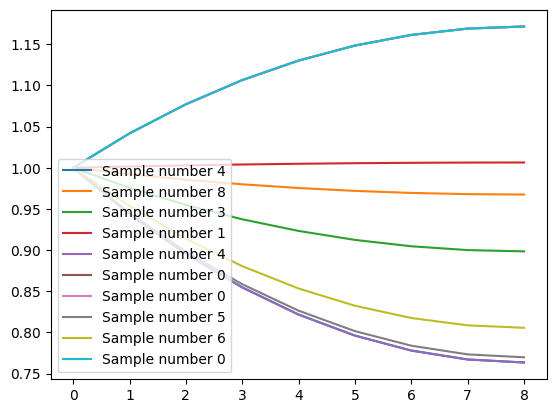

In [7]:
num_plots = 10
for i in range(num_plots):
  picked = np.random.randint(0, NUM_DATA_TRAINING-1) 
  label =  'Sample number {}'.format(picked)
  plt.plot(X_train[picked,:],label=label)

plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()

## Reduce !!!!!Para CD hay que sacar la primer fila (las 400s)

In [8]:
X_train_reduced = X_train[:NUM_DATA_TRAINING,1:]
print("the shape of X_train_reduced is", X_train_reduced.shape)

Y_train_reduced = Y_train[:NUM_DATA_TRAINING]
print("the shape of Y_train_reduced is", Y_train_reduced.shape)

the shape of X_train_reduced is (10, 8)
the shape of Y_train_reduced is (10, 1)


### Normalize

In [9]:
def normalize(xi, xmax, xmin):
    return 2 * (xi - xmin) / (xmax - xmin) - 1

num_col_Xr = X_train_reduced.shape[1]
min_x = [np.min(X_train_reduced[:,col_T]) for col_T in range(num_col_Xr)]
max_x = [np.max(X_train_reduced[:,col_T]) for col_T in range(num_col_Xr)]
min_y = [np.min(Y_train_reduced[:,col_T]) for col_T in range(num_col_Y)]
max_y = [np.max(Y_train_reduced[:,col_T]) for col_T in range(num_col_Y)]

normalized_X_reduced_train = np.copy(X_train_reduced)
normalized_Y_reduced_train = np.copy(Y_train_reduced)

for col in range(num_col_Xr): 
  for row in range(NUM_DATA_TRAINING):
    normalized_X_reduced_train[row,col] = normalize(X_train_reduced[row,col], max_x[col] , min_x[col])
    if col == 0:
        normalized_Y_reduced_train[row,col] = normalize(Y_train_reduced[row,col], max_y[col] , min_y[col])
        

### Ploting normalized $\theta(x)$ for a random G value

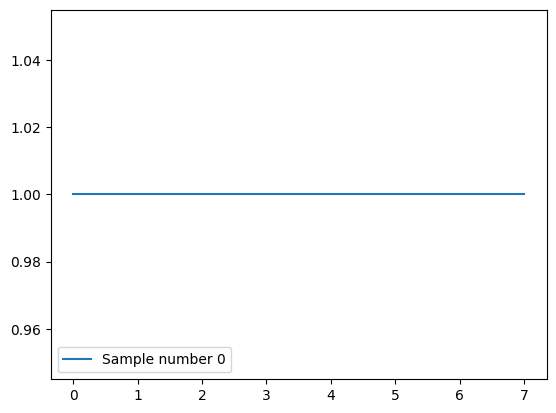

In [10]:
num_plots = 1
for i in range(num_plots):
  picked = np.random.randint(0, NUM_DATA_TRAINING) 
  label =  'Sample number {}'.format(picked)
  plt.plot(normalized_X_reduced_train[picked,:],label=label)
plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()



### Ploting normalized $\theta(x_i)$ for all G values $ \forall i \in [1:8]$


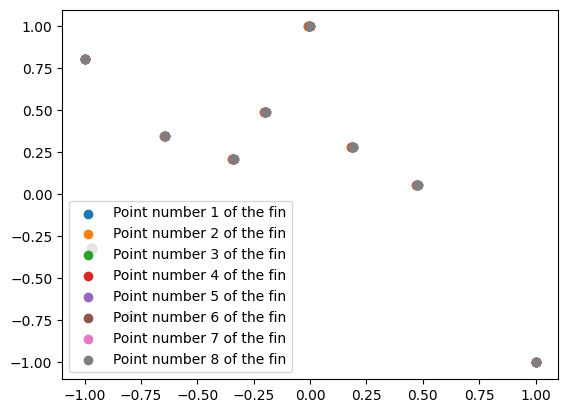

In [11]:
for i in range(num_col_Xr):
    label =  'Point number {} of the fin'.format(i+1)
    plt.scatter(normalized_X_reduced_train[:,i],normalized_Y_reduced_train,label=label)
plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()


## Comment
Pareceria que no importa como todos los X_i se comportan igual con G...
A la Vanilla no le agregaria información agrfegarle todos los X_i, solo entrenandola con X_3 funcionaria.

### NN

Adam Optimization
Epoch: 01/5000 Loss: 3.52985e-01
Epoch: 02/5000 Loss: 3.49880e-01
Epoch: 03/5000 Loss: 3.46973e-01
Epoch: 04/5000 Loss: 3.44258e-01
Epoch: 05/5000 Loss: 3.41736e-01
Epoch: 06/5000 Loss: 3.39397e-01
Epoch: 07/5000 Loss: 3.37210e-01
Epoch: 08/5000 Loss: 3.35128e-01
Epoch: 09/5000 Loss: 3.33088e-01
Epoch: 10/5000 Loss: 3.31022e-01
Epoch: 11/5000 Loss: 3.28868e-01
Epoch: 12/5000 Loss: 3.26582e-01
Epoch: 13/5000 Loss: 3.24138e-01
Epoch: 14/5000 Loss: 3.21527e-01
Epoch: 15/5000 Loss: 3.18751e-01
Epoch: 16/5000 Loss: 3.15817e-01
Epoch: 17/5000 Loss: 3.12735e-01
Epoch: 18/5000 Loss: 3.09519e-01
Epoch: 19/5000 Loss: 3.06175e-01
Epoch: 20/5000 Loss: 3.02699e-01
Epoch: 21/5000 Loss: 2.99079e-01
Epoch: 22/5000 Loss: 2.95294e-01
Epoch: 23/5000 Loss: 2.91320e-01
Epoch: 24/5000 Loss: 2.87130e-01
Epoch: 25/5000 Loss: 2.82702e-01
Epoch: 26/5000 Loss: 2.78026e-01
Epoch: 27/5000 Loss: 2.73104e-01
Epoch: 28/5000 Loss: 2.67945e-01
Epoch: 29/5000 Loss: 2.62570e-01
Epoch: 30/5000 Loss: 2.56

Epoch: 275/5000 Loss: 1.18908e-01
Epoch: 276/5000 Loss: 1.18007e-01
Epoch: 277/5000 Loss: 1.17645e-01
Epoch: 278/5000 Loss: 1.17431e-01
Epoch: 279/5000 Loss: 1.16797e-01
Epoch: 280/5000 Loss: 1.15863e-01
Epoch: 281/5000 Loss: 1.15156e-01
Epoch: 282/5000 Loss: 1.14738e-01
Epoch: 283/5000 Loss: 1.14210e-01
Epoch: 284/5000 Loss: 1.13369e-01
Epoch: 285/5000 Loss: 1.12458e-01
Epoch: 286/5000 Loss: 1.11736e-01
Epoch: 287/5000 Loss: 1.11120e-01
Epoch: 288/5000 Loss: 1.10376e-01
Epoch: 289/5000 Loss: 1.09437e-01
Epoch: 290/5000 Loss: 1.08456e-01
Epoch: 291/5000 Loss: 1.07568e-01
Epoch: 292/5000 Loss: 1.06738e-01
Epoch: 293/5000 Loss: 1.05853e-01
Epoch: 294/5000 Loss: 1.04844e-01
Epoch: 295/5000 Loss: 1.03750e-01
Epoch: 296/5000 Loss: 1.02645e-01
Epoch: 297/5000 Loss: 1.01571e-01
Epoch: 298/5000 Loss: 1.00514e-01
Epoch: 299/5000 Loss: 9.94307e-02
Epoch: 300/5000 Loss: 9.82969e-02
Epoch: 301/5000 Loss: 9.71011e-02
Epoch: 302/5000 Loss: 9.58596e-02
Epoch: 303/5000 Loss: 9.45852e-02
Epoch: 304/500

Epoch: 540/5000 Loss: 1.66206e-02
Epoch: 541/5000 Loss: 1.64909e-02
Epoch: 542/5000 Loss: 1.63674e-02
Epoch: 543/5000 Loss: 1.62751e-02
Epoch: 544/5000 Loss: 1.62263e-02
Epoch: 545/5000 Loss: 1.62190e-02
Epoch: 546/5000 Loss: 1.62413e-02
Epoch: 547/5000 Loss: 1.62745e-02
Epoch: 548/5000 Loss: 1.63004e-02
Epoch: 549/5000 Loss: 1.62973e-02
Epoch: 550/5000 Loss: 1.62566e-02
Epoch: 551/5000 Loss: 1.61772e-02
Epoch: 552/5000 Loss: 1.60817e-02
Epoch: 553/5000 Loss: 1.59950e-02
Epoch: 554/5000 Loss: 1.59386e-02
Epoch: 555/5000 Loss: 1.59159e-02
Epoch: 556/5000 Loss: 1.59130e-02
Epoch: 557/5000 Loss: 1.59089e-02
Epoch: 558/5000 Loss: 1.58841e-02
Epoch: 559/5000 Loss: 1.58291e-02
Epoch: 560/5000 Loss: 1.57492e-02
Epoch: 561/5000 Loss: 1.56604e-02
Epoch: 562/5000 Loss: 1.55817e-02
Epoch: 563/5000 Loss: 1.55251e-02
Epoch: 564/5000 Loss: 1.54911e-02
Epoch: 565/5000 Loss: 1.54717e-02
Epoch: 566/5000 Loss: 1.54560e-02
Epoch: 567/5000 Loss: 1.54345e-02
Epoch: 568/5000 Loss: 1.54031e-02
Epoch: 569/500

Epoch: 789/5000 Loss: 1.33930e-02
Epoch: 790/5000 Loss: 1.33943e-02
Epoch: 791/5000 Loss: 1.34026e-02
Epoch: 792/5000 Loss: 1.34117e-02
Epoch: 793/5000 Loss: 1.34168e-02
Epoch: 794/5000 Loss: 1.34156e-02
Epoch: 795/5000 Loss: 1.34085e-02
Epoch: 796/5000 Loss: 1.33978e-02
Epoch: 797/5000 Loss: 1.33869e-02
Epoch: 798/5000 Loss: 1.33786e-02
Epoch: 799/5000 Loss: 1.33742e-02
Epoch: 800/5000 Loss: 1.33737e-02
Epoch: 801/5000 Loss: 1.33755e-02
Epoch: 802/5000 Loss: 1.33778e-02
Epoch: 803/5000 Loss: 1.33790e-02
Epoch: 804/5000 Loss: 1.33785e-02
Epoch: 805/5000 Loss: 1.33760e-02
Epoch: 806/5000 Loss: 1.33722e-02
Epoch: 807/5000 Loss: 1.33676e-02
Epoch: 808/5000 Loss: 1.33628e-02
Epoch: 809/5000 Loss: 1.33586e-02
Epoch: 810/5000 Loss: 1.33552e-02
Epoch: 811/5000 Loss: 1.33528e-02
Epoch: 812/5000 Loss: 1.33512e-02
Epoch: 813/5000 Loss: 1.33502e-02
Epoch: 814/5000 Loss: 1.33494e-02
Epoch: 815/5000 Loss: 1.33487e-02
Epoch: 816/5000 Loss: 1.33477e-02
Epoch: 817/5000 Loss: 1.33465e-02
Epoch: 818/500

Epoch: 1053/5000 Loss: 1.28323e-02
Epoch: 1054/5000 Loss: 1.28300e-02
Epoch: 1055/5000 Loss: 1.28281e-02
Epoch: 1056/5000 Loss: 1.28256e-02
Epoch: 1057/5000 Loss: 1.28227e-02
Epoch: 1058/5000 Loss: 1.28194e-02
Epoch: 1059/5000 Loss: 1.28165e-02
Epoch: 1060/5000 Loss: 1.28137e-02
Epoch: 1061/5000 Loss: 1.28109e-02
Epoch: 1062/5000 Loss: 1.28078e-02
Epoch: 1063/5000 Loss: 1.28046e-02
Epoch: 1064/5000 Loss: 1.28013e-02
Epoch: 1065/5000 Loss: 1.27984e-02
Epoch: 1066/5000 Loss: 1.27958e-02
Epoch: 1067/5000 Loss: 1.27933e-02
Epoch: 1068/5000 Loss: 1.27907e-02
Epoch: 1069/5000 Loss: 1.27877e-02
Epoch: 1070/5000 Loss: 1.27845e-02
Epoch: 1071/5000 Loss: 1.27814e-02
Epoch: 1072/5000 Loss: 1.27783e-02
Epoch: 1073/5000 Loss: 1.27754e-02
Epoch: 1074/5000 Loss: 1.27725e-02
Epoch: 1075/5000 Loss: 1.27696e-02
Epoch: 1076/5000 Loss: 1.27666e-02
Epoch: 1077/5000 Loss: 1.27636e-02
Epoch: 1078/5000 Loss: 1.27606e-02
Epoch: 1079/5000 Loss: 1.27577e-02
Epoch: 1080/5000 Loss: 1.27548e-02
Epoch: 1081/5000 Los

Epoch: 1315/5000 Loss: 1.24700e-02
Epoch: 1316/5000 Loss: 1.38789e-02
Epoch: 1317/5000 Loss: 1.41471e-02
Epoch: 1318/5000 Loss: 1.30658e-02
Epoch: 1319/5000 Loss: 1.22359e-02
Epoch: 1320/5000 Loss: 1.24450e-02
Epoch: 1321/5000 Loss: 1.28620e-02
Epoch: 1322/5000 Loss: 1.27564e-02
Epoch: 1323/5000 Loss: 1.23819e-02
Epoch: 1324/5000 Loss: 1.21532e-02
Epoch: 1325/5000 Loss: 1.21459e-02
Epoch: 1326/5000 Loss: 1.22716e-02
Epoch: 1327/5000 Loss: 1.23024e-02
Epoch: 1328/5000 Loss: 1.20578e-02
Epoch: 1329/5000 Loss: 1.18251e-02
Epoch: 1330/5000 Loss: 1.19541e-02
Epoch: 1331/5000 Loss: 1.21367e-02
Epoch: 1332/5000 Loss: 1.19419e-02
Epoch: 1333/5000 Loss: 1.16738e-02
Epoch: 1334/5000 Loss: 1.17882e-02
Epoch: 1335/5000 Loss: 1.19787e-02
Epoch: 1336/5000 Loss: 1.18174e-02
Epoch: 1337/5000 Loss: 1.16029e-02
Epoch: 1338/5000 Loss: 1.17022e-02
Epoch: 1339/5000 Loss: 1.18351e-02
Epoch: 1340/5000 Loss: 1.17083e-02
Epoch: 1341/5000 Loss: 1.15722e-02
Epoch: 1342/5000 Loss: 1.16457e-02
Epoch: 1343/5000 Los

Epoch: 1578/5000 Loss: 9.17116e-03
Epoch: 1579/5000 Loss: 9.75414e-03
Epoch: 1580/5000 Loss: 9.61753e-03
Epoch: 1581/5000 Loss: 8.95115e-03
Epoch: 1582/5000 Loss: 8.63435e-03
Epoch: 1583/5000 Loss: 8.92701e-03
Epoch: 1584/5000 Loss: 9.23709e-03
Epoch: 1585/5000 Loss: 9.06997e-03
Epoch: 1586/5000 Loss: 8.66335e-03
Epoch: 1587/5000 Loss: 8.54996e-03
Epoch: 1588/5000 Loss: 8.76279e-03
Epoch: 1589/5000 Loss: 8.88438e-03
Epoch: 1590/5000 Loss: 8.70610e-03
Epoch: 1591/5000 Loss: 8.47195e-03
Epoch: 1592/5000 Loss: 8.46509e-03
Epoch: 1593/5000 Loss: 8.60128e-03
Epoch: 1594/5000 Loss: 8.61395e-03
Epoch: 1595/5000 Loss: 8.46124e-03
Epoch: 1596/5000 Loss: 8.33917e-03
Epoch: 1597/5000 Loss: 8.36680e-03
Epoch: 1598/5000 Loss: 8.43461e-03
Epoch: 1599/5000 Loss: 8.39979e-03
Epoch: 1600/5000 Loss: 8.28934e-03
Epoch: 1601/5000 Loss: 8.22790e-03
Epoch: 1602/5000 Loss: 8.25055e-03
Epoch: 1603/5000 Loss: 8.27319e-03
Epoch: 1604/5000 Loss: 8.22825e-03
Epoch: 1605/5000 Loss: 8.15222e-03
Epoch: 1606/5000 Los

Epoch: 1850/5000 Loss: 1.08456e-03
Epoch: 1851/5000 Loss: 1.06701e-03
Epoch: 1852/5000 Loss: 1.04799e-03
Epoch: 1853/5000 Loss: 1.03035e-03
Epoch: 1854/5000 Loss: 1.01496e-03
Epoch: 1855/5000 Loss: 1.00006e-03
Epoch: 1856/5000 Loss: 9.83885e-04
Epoch: 1857/5000 Loss: 9.66701e-04
Epoch: 1858/5000 Loss: 9.50139e-04
Epoch: 1859/5000 Loss: 9.34971e-04
Epoch: 1860/5000 Loss: 9.20431e-04
Epoch: 1861/5000 Loss: 9.05389e-04
Epoch: 1862/5000 Loss: 8.89704e-04
Epoch: 1863/5000 Loss: 8.74178e-04
Epoch: 1864/5000 Loss: 8.59464e-04
Epoch: 1865/5000 Loss: 8.45389e-04
Epoch: 1866/5000 Loss: 8.31292e-04
Epoch: 1867/5000 Loss: 8.16856e-04
Epoch: 1868/5000 Loss: 8.02364e-04
Epoch: 1869/5000 Loss: 7.88297e-04
Epoch: 1870/5000 Loss: 7.74755e-04
Epoch: 1871/5000 Loss: 7.61440e-04
Epoch: 1872/5000 Loss: 7.48046e-04
Epoch: 1873/5000 Loss: 7.34582e-04
Epoch: 1874/5000 Loss: 7.21297e-04
Epoch: 1875/5000 Loss: 7.08368e-04
Epoch: 1876/5000 Loss: 6.95739e-04
Epoch: 1877/5000 Loss: 6.83231e-04
Epoch: 1878/5000 Los

Epoch: 2109/5000 Loss: 2.34518e-06
Epoch: 2110/5000 Loss: 1.79828e-06
Epoch: 2111/5000 Loss: 1.31467e-06
Epoch: 2112/5000 Loss: 1.31346e-06
Epoch: 2113/5000 Loss: 1.51188e-06
Epoch: 2114/5000 Loss: 1.49546e-06
Epoch: 2115/5000 Loss: 1.24150e-06
Epoch: 2116/5000 Loss: 1.01049e-06
Epoch: 2117/5000 Loss: 9.60583e-07
Epoch: 2118/5000 Loss: 1.01248e-06
Epoch: 2119/5000 Loss: 1.01526e-06
Epoch: 2120/5000 Loss: 9.13527e-07
Epoch: 2121/5000 Loss: 7.74667e-07
Epoch: 2122/5000 Loss: 6.93630e-07
Epoch: 2123/5000 Loss: 6.98683e-07
Epoch: 2124/5000 Loss: 7.25573e-07
Epoch: 2125/5000 Loss: 6.92023e-07
Epoch: 2126/5000 Loss: 5.93551e-07
Epoch: 2127/5000 Loss: 5.09509e-07
Epoch: 2128/5000 Loss: 5.01248e-07
Epoch: 2129/5000 Loss: 5.35620e-07
Epoch: 2130/5000 Loss: 5.30385e-07
Epoch: 2131/5000 Loss: 4.59978e-07
Epoch: 2132/5000 Loss: 3.86606e-07
Epoch: 2133/5000 Loss: 3.73173e-07
Epoch: 2134/5000 Loss: 4.03475e-07
Epoch: 2135/5000 Loss: 4.09773e-07
Epoch: 2136/5000 Loss: 3.62154e-07
Epoch: 2137/5000 Los

Epoch: 2373/5000 Loss: 8.23707e-06
Epoch: 2374/5000 Loss: 1.48539e-05
Epoch: 2375/5000 Loss: 2.70023e-05
Epoch: 2376/5000 Loss: 4.92802e-05
Epoch: 2377/5000 Loss: 9.05877e-05
Epoch: 2378/5000 Loss: 1.66276e-04
Epoch: 2379/5000 Loss: 3.06014e-04
Epoch: 2380/5000 Loss: 5.54418e-04
Epoch: 2381/5000 Loss: 9.92150e-04
Epoch: 2382/5000 Loss: 1.68814e-03
Epoch: 2383/5000 Loss: 2.73943e-03
Epoch: 2384/5000 Loss: 3.98659e-03
Epoch: 2385/5000 Loss: 5.34970e-03
Epoch: 2386/5000 Loss: 6.12655e-03
Epoch: 2387/5000 Loss: 6.06870e-03
Epoch: 2388/5000 Loss: 4.19741e-03
Epoch: 2389/5000 Loss: 1.56704e-03
Epoch: 2390/5000 Loss: 6.67647e-04
Epoch: 2391/5000 Loss: 2.14011e-03
Epoch: 2392/5000 Loss: 3.31894e-03
Epoch: 2393/5000 Loss: 1.88094e-03
Epoch: 2394/5000 Loss: 1.45908e-04
Epoch: 2395/5000 Loss: 8.91163e-04
Epoch: 2396/5000 Loss: 2.13618e-03
Epoch: 2397/5000 Loss: 1.26010e-03
Epoch: 2398/5000 Loss: 3.77285e-05
Epoch: 2399/5000 Loss: 6.81466e-04
Epoch: 2400/5000 Loss: 1.38127e-03
Epoch: 2401/5000 Los

Epoch: 2641/5000 Loss: 2.14915e-11
Epoch: 2642/5000 Loss: 2.01048e-11
Epoch: 2643/5000 Loss: 2.05995e-11
Epoch: 2644/5000 Loss: 1.94629e-11
Epoch: 2645/5000 Loss: 1.76515e-11
Epoch: 2646/5000 Loss: 1.66559e-11
Epoch: 2647/5000 Loss: 1.64077e-11
Epoch: 2648/5000 Loss: 1.58250e-11
Epoch: 2649/5000 Loss: 1.45375e-11
Epoch: 2650/5000 Loss: 1.40242e-11
Epoch: 2651/5000 Loss: 1.43379e-11
Epoch: 2652/5000 Loss: 1.36859e-11
Epoch: 2653/5000 Loss: 1.23661e-11
Epoch: 2654/5000 Loss: 1.15414e-11
Epoch: 2655/5000 Loss: 1.19578e-11
Epoch: 2656/5000 Loss: 1.09766e-11
Epoch: 2657/5000 Loss: 1.00064e-11
Epoch: 2658/5000 Loss: 9.86660e-12
Epoch: 2659/5000 Loss: 9.46421e-12
Epoch: 2660/5000 Loss: 9.32530e-12
Epoch: 2661/5000 Loss: 8.59380e-12
Epoch: 2662/5000 Loss: 8.57381e-12
Epoch: 2663/5000 Loss: 8.14043e-12
Epoch: 2664/5000 Loss: 7.52989e-12
Epoch: 2665/5000 Loss: 6.99388e-12
Epoch: 2666/5000 Loss: 7.33181e-12
Epoch: 2667/5000 Loss: 6.81906e-12
Epoch: 2668/5000 Loss: 6.52134e-12
Epoch: 2669/5000 Los

Epoch: 2909/5000 Loss: 9.67096e-07
Epoch: 2910/5000 Loss: 5.93523e-07
Epoch: 2911/5000 Loss: 1.17235e-06
Epoch: 2912/5000 Loss: 9.15780e-07
Epoch: 2913/5000 Loss: 4.74876e-07
Epoch: 2914/5000 Loss: 6.84700e-07
Epoch: 2915/5000 Loss: 8.01576e-07
Epoch: 2916/5000 Loss: 4.27988e-07
Epoch: 2917/5000 Loss: 3.71982e-07
Epoch: 2918/5000 Loss: 6.52277e-07
Epoch: 2919/5000 Loss: 4.05545e-07
Epoch: 2920/5000 Loss: 1.90988e-07
Epoch: 2921/5000 Loss: 4.93788e-07
Epoch: 2922/5000 Loss: 3.81961e-07
Epoch: 2923/5000 Loss: 1.02603e-07
Epoch: 2924/5000 Loss: 3.47992e-07
Epoch: 2925/5000 Loss: 3.44671e-07
Epoch: 2926/5000 Loss: 7.20703e-08
Epoch: 2927/5000 Loss: 2.30516e-07
Epoch: 2928/5000 Loss: 2.94238e-07
Epoch: 2929/5000 Loss: 7.11070e-08
Epoch: 2930/5000 Loss: 1.44984e-07
Epoch: 2931/5000 Loss: 2.34900e-07
Epoch: 2932/5000 Loss: 8.03391e-08
Epoch: 2933/5000 Loss: 9.16312e-08
Epoch: 2934/5000 Loss: 1.75651e-07
Epoch: 2935/5000 Loss: 8.70971e-08
Epoch: 2936/5000 Loss: 6.28394e-08
Epoch: 2937/5000 Los

Epoch: 3175/5000 Loss: 1.23240e-11
Epoch: 3176/5000 Loss: 1.20116e-11
Epoch: 3177/5000 Loss: 3.14356e-12
Epoch: 3178/5000 Loss: 2.29499e-12
Epoch: 3179/5000 Loss: 8.13723e-12
Epoch: 3180/5000 Loss: 8.49870e-12
Epoch: 3181/5000 Loss: 2.66894e-12
Epoch: 3182/5000 Loss: 1.57577e-12
Epoch: 3183/5000 Loss: 6.56860e-12
Epoch: 3184/5000 Loss: 5.98624e-12
Epoch: 3185/5000 Loss: 9.27375e-13
Epoch: 3186/5000 Loss: 1.54137e-12
Epoch: 3187/5000 Loss: 2.12020e-12
Epoch: 3188/5000 Loss: 5.29027e-13
Epoch: 3189/5000 Loss: 1.45775e-12
Epoch: 3190/5000 Loss: 9.74715e-13
Epoch: 3191/5000 Loss: 7.43744e-13
Epoch: 3192/5000 Loss: 1.86582e-12
Epoch: 3193/5000 Loss: 7.91439e-13
Epoch: 3194/5000 Loss: 9.05215e-13
Epoch: 3195/5000 Loss: 1.50189e-12
Epoch: 3196/5000 Loss: 5.78498e-13
Epoch: 3197/5000 Loss: 7.89485e-13
Epoch: 3198/5000 Loss: 5.66241e-13
Epoch: 3199/5000 Loss: 5.57759e-13
Epoch: 3200/5000 Loss: 5.26051e-13
Epoch: 3201/5000 Loss: 5.23165e-13
Epoch: 3202/5000 Loss: 8.22037e-13
Epoch: 3203/5000 Los

Epoch: 3430/5000 Loss: 4.30683e-13
Epoch: 3431/5000 Loss: 1.66717e-13
Epoch: 3432/5000 Loss: 1.62897e-13
Epoch: 3433/5000 Loss: 5.10797e-13
Epoch: 3434/5000 Loss: 2.58071e-14
Epoch: 3435/5000 Loss: 3.24191e-13
Epoch: 3436/5000 Loss: 4.86777e-14
Epoch: 3437/5000 Loss: 3.17574e-13
Epoch: 3438/5000 Loss: 1.49752e-13
Epoch: 3439/5000 Loss: 1.20665e-13
Epoch: 3440/5000 Loss: 1.94561e-13
Epoch: 3441/5000 Loss: 8.83793e-14
Epoch: 3442/5000 Loss: 3.75705e-13
Epoch: 3443/5000 Loss: 4.77896e-14
Epoch: 3444/5000 Loss: 3.51191e-13
Epoch: 3445/5000 Loss: 4.68126e-14
Epoch: 3446/5000 Loss: 1.82127e-13
Epoch: 3447/5000 Loss: 6.61304e-14
Epoch: 3448/5000 Loss: 1.85058e-13
Epoch: 3449/5000 Loss: 1.01391e-13
Epoch: 3450/5000 Loss: 4.54797e-13
Epoch: 3451/5000 Loss: 2.87825e-14
Epoch: 3452/5000 Loss: 4.48580e-13
Epoch: 3453/5000 Loss: 5.42733e-14
Epoch: 3454/5000 Loss: 2.49051e-13
Epoch: 3455/5000 Loss: 2.93904e-13
Epoch: 3456/5000 Loss: 4.40592e-14
Epoch: 3457/5000 Loss: 3.15620e-13
Epoch: 3458/5000 Los

Epoch: 3708/5000 Loss: 4.38456e-11
Epoch: 3709/5000 Loss: 4.29642e-11
Epoch: 3710/5000 Loss: 4.02874e-11
Epoch: 3711/5000 Loss: 3.37250e-11
Epoch: 3712/5000 Loss: 3.66345e-11
Epoch: 3713/5000 Loss: 3.34298e-11
Epoch: 3714/5000 Loss: 2.95919e-11
Epoch: 3715/5000 Loss: 2.82110e-11
Epoch: 3716/5000 Loss: 2.67943e-11
Epoch: 3717/5000 Loss: 2.64054e-11
Epoch: 3718/5000 Loss: 2.30527e-11
Epoch: 3719/5000 Loss: 2.16015e-11
Epoch: 3720/5000 Loss: 2.37415e-11
Epoch: 3721/5000 Loss: 2.03556e-11
Epoch: 3722/5000 Loss: 1.81256e-11
Epoch: 3723/5000 Loss: 1.86090e-11
Epoch: 3724/5000 Loss: 1.68420e-11
Epoch: 3725/5000 Loss: 1.62455e-11
Epoch: 3726/5000 Loss: 1.42217e-11
Epoch: 3727/5000 Loss: 1.26849e-11
Epoch: 3728/5000 Loss: 1.31104e-11
Epoch: 3729/5000 Loss: 1.15026e-11
Epoch: 3730/5000 Loss: 1.09929e-11
Epoch: 3731/5000 Loss: 1.11131e-11
Epoch: 3732/5000 Loss: 9.49397e-12
Epoch: 3733/5000 Loss: 9.05294e-12
Epoch: 3734/5000 Loss: 1.01388e-11
Epoch: 3735/5000 Loss: 1.07181e-11
Epoch: 3736/5000 Los

Epoch: 3978/5000 Loss: 4.03438e-13
Epoch: 3979/5000 Loss: 1.85169e-13
Epoch: 3980/5000 Loss: 1.21279e-12
Epoch: 3981/5000 Loss: 1.46666e-13
Epoch: 3982/5000 Loss: 9.60726e-13
Epoch: 3983/5000 Loss: 1.04075e-12
Epoch: 3984/5000 Loss: 1.25041e-12
Epoch: 3985/5000 Loss: 1.97627e-12
Epoch: 3986/5000 Loss: 2.40680e-13
Epoch: 3987/5000 Loss: 7.46275e-13
Epoch: 3988/5000 Loss: 1.01939e-12
Epoch: 3989/5000 Loss: 1.06209e-13
Epoch: 3990/5000 Loss: 1.51650e-12
Epoch: 3991/5000 Loss: 7.98189e-13
Epoch: 3992/5000 Loss: 2.11992e-13
Epoch: 3993/5000 Loss: 1.14262e-12
Epoch: 3994/5000 Loss: 1.38894e-12
Epoch: 3995/5000 Loss: 1.00327e-12
Epoch: 3996/5000 Loss: 2.87159e-14
Epoch: 3997/5000 Loss: 2.09149e-13
Epoch: 3998/5000 Loss: 6.37990e-14
Epoch: 3999/5000 Loss: 3.52057e-13
Epoch: 4000/5000 Loss: 8.73801e-14
Epoch: 4001/5000 Loss: 1.33210e-13
Epoch: 4002/5000 Loss: 4.30156e-14
Epoch: 4003/5000 Loss: 1.32944e-13
Epoch: 4004/5000 Loss: 4.17277e-14
Epoch: 4005/5000 Loss: 1.65051e-13
Epoch: 4006/5000 Los

Epoch: 4249/5000 Loss: 1.19795e-10
Epoch: 4250/5000 Loss: 1.23323e-10
Epoch: 4251/5000 Loss: 9.96067e-11
Epoch: 4252/5000 Loss: 9.68266e-11
Epoch: 4253/5000 Loss: 1.03165e-10
Epoch: 4254/5000 Loss: 7.87036e-11
Epoch: 4255/5000 Loss: 7.82842e-11
Epoch: 4256/5000 Loss: 8.00946e-11
Epoch: 4257/5000 Loss: 6.07632e-11
Epoch: 4258/5000 Loss: 6.23375e-11
Epoch: 4259/5000 Loss: 5.99017e-11
Epoch: 4260/5000 Loss: 4.85736e-11
Epoch: 4261/5000 Loss: 5.16343e-11
Epoch: 4262/5000 Loss: 4.40446e-11
Epoch: 4263/5000 Loss: 4.10088e-11
Epoch: 4264/5000 Loss: 4.11661e-11
Epoch: 4265/5000 Loss: 3.53012e-11
Epoch: 4266/5000 Loss: 3.43858e-11
Epoch: 4267/5000 Loss: 3.17697e-11
Epoch: 4268/5000 Loss: 2.90827e-11
Epoch: 4269/5000 Loss: 2.66861e-11
Epoch: 4270/5000 Loss: 2.50169e-11
Epoch: 4271/5000 Loss: 2.48046e-11
Epoch: 4272/5000 Loss: 2.05133e-11
Epoch: 4273/5000 Loss: 2.07996e-11
Epoch: 4274/5000 Loss: 1.81640e-11
Epoch: 4275/5000 Loss: 1.70276e-11
Epoch: 4276/5000 Loss: 1.57490e-11
Epoch: 4277/5000 Los

Epoch: 4488/5000 Loss: 1.65479e-14
Epoch: 4489/5000 Loss: 1.35725e-14
Epoch: 4490/5000 Loss: 7.04437e-15
Epoch: 4491/5000 Loss: 3.00482e-14
Epoch: 4492/5000 Loss: 1.38833e-14
Epoch: 4493/5000 Loss: 2.10332e-14
Epoch: 4494/5000 Loss: 1.70808e-14
Epoch: 4495/5000 Loss: 1.57485e-14
Epoch: 4496/5000 Loss: 2.48079e-14
Epoch: 4497/5000 Loss: 1.77025e-14
Epoch: 4498/5000 Loss: 2.64955e-14
Epoch: 4499/5000 Loss: 2.43638e-14
Epoch: 4500/5000 Loss: 3.35565e-14
Epoch: 4501/5000 Loss: 3.37341e-14
Epoch: 4502/5000 Loss: 2.15661e-14
Epoch: 4503/5000 Loss: 2.72504e-14
Epoch: 4504/5000 Loss: 2.07223e-14
Epoch: 4505/5000 Loss: 3.23575e-14
Epoch: 4506/5000 Loss: 3.09364e-14
Epoch: 4507/5000 Loss: 1.99674e-14
Epoch: 4508/5000 Loss: 2.84495e-14
Epoch: 4509/5000 Loss: 2.96929e-14
Epoch: 4510/5000 Loss: 3.14249e-14
Epoch: 4511/5000 Loss: 3.42226e-14
Epoch: 4512/5000 Loss: 2.80498e-14
Epoch: 4513/5000 Loss: 3.98626e-14
Epoch: 4514/5000 Loss: 3.80862e-14
Epoch: 4515/5000 Loss: 3.45779e-14
Epoch: 4516/5000 Los

Epoch: 4762/5000 Loss: 1.46383e-14
Epoch: 4763/5000 Loss: 1.23290e-14
Epoch: 4764/5000 Loss: 2.14329e-14
Epoch: 4765/5000 Loss: 2.41862e-14
Epoch: 4766/5000 Loss: 1.28175e-14
Epoch: 4767/5000 Loss: 2.05003e-14
Epoch: 4768/5000 Loss: 1.34837e-14
Epoch: 4769/5000 Loss: 1.01086e-14
Epoch: 4770/5000 Loss: 3.10696e-14
Epoch: 4771/5000 Loss: 3.24907e-14
Epoch: 4772/5000 Loss: 1.40166e-14
Epoch: 4773/5000 Loss: 2.47191e-14
Epoch: 4774/5000 Loss: 2.79166e-14
Epoch: 4775/5000 Loss: 1.20626e-14
Epoch: 4776/5000 Loss: 2.29872e-14
Epoch: 4777/5000 Loss: 2.84495e-14
Epoch: 4778/5000 Loss: 2.22766e-14
Epoch: 4779/5000 Loss: 9.13158e-15
Epoch: 4780/5000 Loss: 6.86673e-15
Epoch: 4781/5000 Loss: 1.53932e-14
Epoch: 4782/5000 Loss: 1.58373e-14
Epoch: 4783/5000 Loss: 1.63702e-14
Epoch: 4784/5000 Loss: 1.61926e-14
Epoch: 4785/5000 Loss: 2.55629e-14
Epoch: 4786/5000 Loss: 2.59182e-14
Epoch: 4787/5000 Loss: 1.92568e-14
Epoch: 4788/5000 Loss: 2.06335e-14
Epoch: 4789/5000 Loss: 2.84495e-14
Epoch: 4790/5000 Los

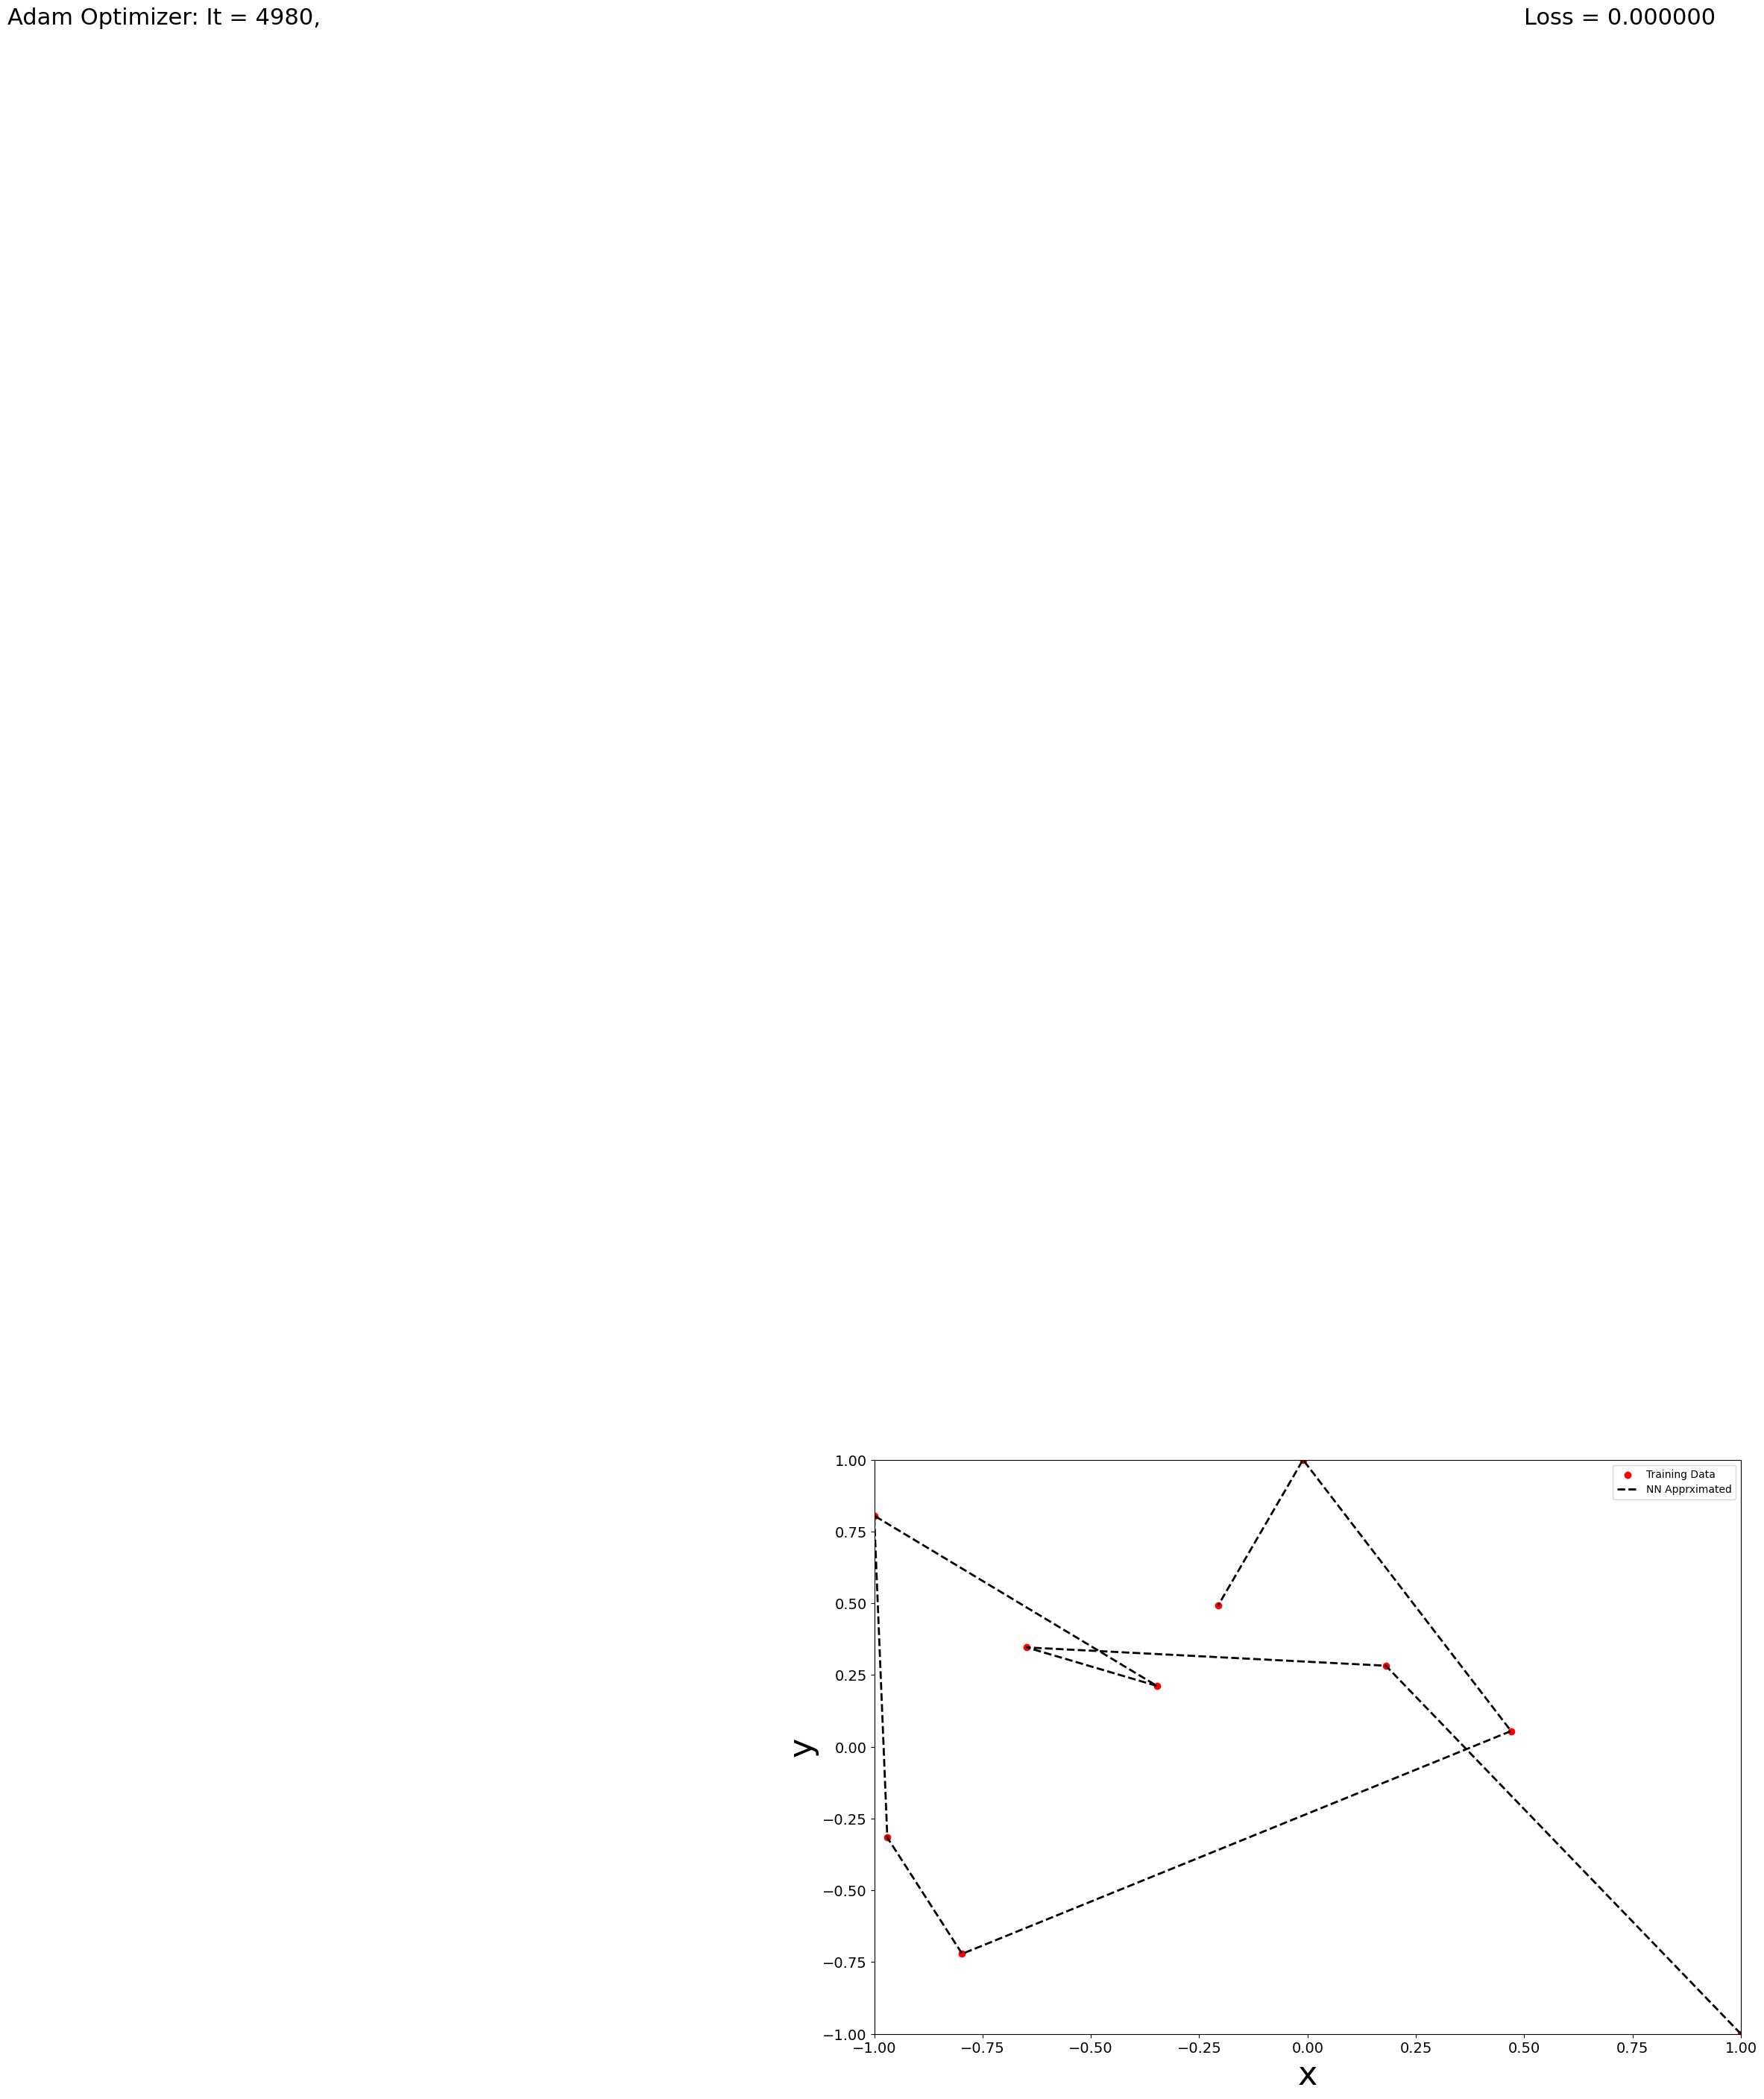

In [12]:
x = torch.from_numpy(normalized_X_reduced_train[:,0].reshape(-1,1)).float()
y = torch.from_numpy(normalized_Y_reduced_train.reshape(-1,num_col_Y)).float()

loss_function = torch.nn.MSELoss()
Niter_Adam = 5000
Num_of_neurons = 32
LearningRate = 1e-3
Inputs = x.size(1)

Net = torch.nn.Sequential(
      torch.nn.Linear(Inputs, Num_of_neurons),
      torch.nn.Tanh(),
      torch.nn.Linear(Num_of_neurons, Num_of_neurons),
      torch.nn.Tanh(),
      torch.nn.Linear(Num_of_neurons, Num_of_neurons),
      torch.nn.Tanh(),
      torch.nn.Linear(Num_of_neurons, Num_of_neurons),
      torch.nn.Tanh(),
      torch.nn.Linear(Num_of_neurons, num_col_Y))

optimizer_adam = torch.optim.Adam(Net.parameters(), lr = LearningRate)
optimizer_lbfgs = LBFGS(Net.parameters(), history_size=5, max_iter=6)

fig, ax = plt.subplots(figsize=(15,10))

image_list = []
adam_only_loss = []
# lbfgs_loss = []


x = Variable(x)
y = Variable(y)

# Implementation of Adam
print('Adam Optimization')
    
for it in range(Niter_Adam):
    y_pred = Net(x)
    loss = loss_function(y_pred, y)  # Notice the order: NN Pred first and then actual value
    optimizer_adam.zero_grad()       # Zero Out the gradient
    loss.backward()
    optimizer_adam.step()    
    #optimizer.step(closure)
    #loss = closure()
    adam_only_loss.append(loss)
    print(f"Epoch: {it + 1:02}/{Niter_Adam} Loss: {loss:.5e}")
    y_pred = Net(x)
    y_test = y_pred.detach().numpy()
    if it%20==0:
        plt.cla()
        ax.set_xlabel('x', fontsize=32)
        ax.set_ylabel('y', fontsize=32)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.scatter(normalized_X_reduced_train[:,0], normalized_Y_reduced_train, color = "red", label="Training Data")
        ax.plot(normalized_X_reduced_train[:,0], y_test, 'k--', lw=2,  label="NN Apprximated")
        ax.text(-3, 6.0, 'Adam Optimizer: It = %d,' %it, fontdict={'size': 22, 'color':  'black'})
        ax.text(0.5, 6.0, 'Loss = %.6f' % loss,
                fontdict={'size': 22, 'color':  'black'})
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend()

        fig.canvas.draw()      
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        image_list.append(image)

imageio.mimsave('./Adam_func.gif', image_list, fps=5)
ep_adam = np.arange(500)+1